# Train a scVI model using Census data

This notebook demonstrates a scalable approach to training an [scVI](https://docs.scvi-tools.org/en/latest/user_guide/models/scvi.html) model on Census data. The [scvi-tools](https://scvi-tools.org/) library is built around [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/). [TileDB-SOMA-ML](https://github.com/single-cell-data/TileDB-SOMA-ML) assists with streaming Census query results to PyTorch in batches, allowing for training datasets larger than available RAM.

## Plan for this tutorial

1. Training the model
2. Generate cell embeddings
3. Analyzing the results

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


## Training the model 

Let's start by importing the necessary dependencies.

In [2]:
import warnings

import cellxgene_census
import numpy as np
import scanpy as sc
import scvi
import tiledbsoma as soma
from cellxgene_census.experimental.pp import highly_variable_genes

# from lightning import LightningDataModule
# from sklearn.preprocessing import LabelEncoder
# from torch.utils.data import DataLoader
from scvi.dataloaders import TileDBDataModule

warnings.filterwarnings("ignore")

→ connected lamindb: anonymous/lamindb_collection


We'll now prepare the necessary parameters for running a training pass of the model.

For this notebook, we'll use a stable version of the Census:

In [3]:
census = cellxgene_census.open_soma(census_version="2023-12-15")

We'll also do two types of filtering.

For **cells**, we will apply a filter to only select primary cells, with at least 300 expressed genes (nnz >= 300). For notebook demonstration purposes, we will also apply a tissue filtering so that the training can happen on a laptop. The same approach can be used on datasets much larger than available RAM. (A GPU is recommended, though.)

For **genes**, we will apply a filter so that only the top highly variable genes (HVG) are included in the training. This is a commonly used dimensionality reduction approach and is recommended on production models as well.

Let's define a few parameters:

In [4]:
experiment_name = "mus_musculus"

In [5]:
# obs_val_filt = ('is_primary_data == True and tissue_general in ["spleen", "kidney"] '
#            'and nnz >= 500')
# obs_val_filt = ('is_primary_data == True and tissue_general in ["kidney"] '
#            'and nnz >= 500 and donor_id not in ["pooled"]')
# obs_val_filt = ('is_primary_data == True and tissue_general in ["liver", "heart"] '
#            'and nnz >= 500')
obs_val_filt = (
    'is_primary_data == True and cell_type in ["B cell","T cell", "macrophage","fibroblast","endothelial","myeloid","lymphocyte","natural killer cell","CD4-positive, alpha-beta T cell","CD8-positive, alpha-beta T cell"] '
    'and donor_id not in ["pooled"] and dataset_id in ["98e5ea9f-16d6-47ec-a529-686e76515e39","58b01044-c5e5-4b0f-8a2d-6ebf951e01ff","48b37086-25f7-4ecd-be66-f5bb378e3aea"] and tissue_general not in ["vasculature"] and nnz >= 300'
)
# obs_val_filt = ('is_primary_data == True and tissue_general in ["blood"] '
#            'and nnz >= 500 and dataset_id in ["9dbab10c-118d-496b-966a-67f1763a6b7d"]')

We define the batch to be a multivariate parameters

In [6]:
batch_keys = [
    "dataset_id",
    "donor_id",
    "assay",
    "tissue_general",
]  # ,"tissue_general","assay", "dataset_id", "disease"

For HVG, we can use the `highly_variable_genes` function provided in `cellxgene_census`, which can compute HVGs in constant memory:

In [7]:
top_n_hvg = 5000
hvgs_df = highly_variable_genes(
    census["census_data"][experiment_name].axis_query(
        measurement_name="RNA", obs_query=soma.AxisQuery(value_filter=obs_val_filt)
    ),
    n_top_genes=top_n_hvg,
    batch_key=batch_keys,
)
hv = hvgs_df.highly_variable
hv_idx = hv[hv].index
# hv_idx = np.arange(10)

Once we know the id's of the HVG's we can select only them using the tiledb query mechanism

In [8]:
hvg_query = census["census_data"][experiment_name].axis_query(
    measurement_name="RNA",
    obs_query=soma.AxisQuery(value_filter=obs_val_filt),
    var_query=soma.AxisQuery(coords=(list(hv_idx),)),
)

We will now introduce a helper class `TileDBDataModule` to connect SCVI with TileDB-SOMA-ML with PyTorch Lightning. It subclasses [`LightningDataModule`](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) and:

1. Uses TileDB-SOMA-ML to prepare a DataLoader for the results of a SOMA [`ExperimentAxisQuery`](https://tiledbsoma.readthedocs.io/en/1.15.0/python-tiledbsoma-experimentaxisquery.html) on the Census.
1. Derives each cell's scVI batch label as a tuple of obs attributes: `dataset_id`, `donor_id`.
    * *Don't confuse each cell's label for scVI "batch" integration with a training data "batch" generated by the DataLoader.*
1. Converts the RNA counts and batch labels to a dict of tensors for each training data batch, as scVI expects.

In [9]:
datamodule = TileDBDataModule(
    hvg_query,
    layer_name="raw",
    batch_size=1024,
    shuffle=True,
    seed=42,
    batch_column_names=batch_keys,
    dataloader_kwargs={"num_workers": 0, "persistent_workers": False},
    accelerator="gpu",
    device=1,
    return_sparse_X=False,
)
print(datamodule.n_obs, datamodule.n_vars, datamodule.n_batch)

114440 5000 307


Most parameters to `TileDBDataModule` are passed through to the [`tiledbsoma_ml.ExperimentDataset`](https://single-cell-data.github.io/TileDB-SOMA-ML/#tiledbsoma_ml.ExperimentDataset) initializer; see that documentation to understand how it can be tuned.

In particular, here are some parameters of interest:

* `shuffle`: shuffles the result cell order, which is often advisable for model training.
* `batch_size`: controls the size (number of cells) in each training data batch, in turn controlling memory usage.
* `dataloader_kwargs`: [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) tuning, for example controlling parallelization.

We can now create the scVI model object:

In [10]:
n_layers = 1
n_latent = 10
datamodule.setup()
model = scvi.model.SCVI(
    adata=None,
    registry=datamodule.registry,
    n_layers=n_layers,
    n_latent=n_latent,
)

In [11]:
# creating the dataloader for trainset
# training_dataloader = (
#    datamodule.on_before_batch_transfer(batch, None) for batch in datamodule.train_dataloader()
# )

In [12]:
import gc

gc.collect()
# del model
# del datamodule

43627

Then, we can invoke the `.train` method which will start the training loop.

In [13]:
import time

start = time.time()
model.train(
    datamodule=datamodule,
    max_epochs=20,
    batch_size=1024,
    plan_kwargs={"lr": 2e-2},
    early_stopping=False,
    # accelerator="gpu",
    # devices=-1,
    # strategy="ddp_find_unused_parameters_true",
)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/20 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Elapsed time: 9221.03 seconds


In [14]:
model.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

In [15]:
model.history["elbo_train"]

elbo_train
epoch             
0      3955.794922
1      3378.413818
2      3270.247314
3      3224.349854
4      3203.736816
5       3191.08667
6      3180.475342
7      3173.039062
8       3164.07666
9      3156.658203
10     3150.084473
11     3144.045654
12     3138.294678
13     3132.830078
14     3128.165527
15     3124.053467
16     3120.172607
17     3116.529297
18     3113.744385
19     3110.794922

We can now save the trained model. As of the current writing, scvi-tools doesn't support saving a model that wasn't generated through an AnnData loader, so we'll use some custom code:

In [16]:
model.save("census_model", save_anndata=False, overwrite=True, datamodule=datamodule)

We will now load the model back and use it to generate cell embeddings (the latent space), which can then be used for further analysis. Loading the model similarly involves some custom code.

In [17]:
# scvi.model.SCVI.load("census_model", adata=False)

## Generate cell embeddings

We will now generate the cell embeddings for this model, using the `get_latent_representation` function available in scvi-tools. 

We can use another instance of the `SCVIDataModule` for the forward pass, so we don't need to load the whole dataset in memory. This will have shuffling disabled to make it easier to join the embeddings later. We also want to restore the list of scVI batch labels from the training data, ensuring our forward pass will map batch labels to tensors in the expected way (although this specific example would work regardless, since it reuses the same query).

In [18]:
inference_datamodule = TileDBDataModule(
    hvg_query,
    layer_name="raw",
    batch_labels=datamodule.batch_labels,
    batch_size=1024,
    shuffle=False,
    batch_column_names=batch_keys,
    dataloader_kwargs={"num_workers": 0, "persistent_workers": False},
)
inference_datamodule.setup()

To feed the data to `get_latent_representation`, we operate `inference_datamodule` as PyTorch Lightning would during training:

In [19]:
latent = model.get_latent_representation(dataloader=inference_datamodule.inference_dataloader())
latent.shape

(114440, 10)

We successfully trained the model and generated embeddings using limited memory. Even on the full Census, this has been tested to run with less than 30G of memory.

## Analyzing the results

We will now take a look at the UMAP for the generated embedding. Note that we need to extract the adata out of the census data.

In order to do this, we'll use `scanpy` which accepts an AnnData object, so we'll generate one using the `get_anndata` utility function:

In [20]:
adata = cellxgene_census.get_anndata(
    census,
    organism=experiment_name,
    obs_value_filter=obs_val_filt,
)

Add the generated embedding (stored in `latent`) in the obsm slot of the AnnData object:

In [21]:
# verify cell order:
assert np.array_equal(
    np.array(adata.obs["soma_joinid"]), inference_datamodule.train_dataset.query_ids.obs_joinids
)

adata.obsm["scvi"] = latent

We can now generate the neighbors and the UMAP.

In [22]:
# adata = adata[~adata.obs["cell_type"].str.contains("kidney", na=False)]
# adata.obs.loc[adata.obs.cell_type.isin(["CD8-positive, alpha-beta T cell","CD4-positive, alpha-beta T cell"],"cell_type"] = "T cell"

In [23]:
sc.pp.neighbors(adata, use_rep="scvi", key_added="scvi")
sc.tl.umap(adata, neighbors_key="scvi")

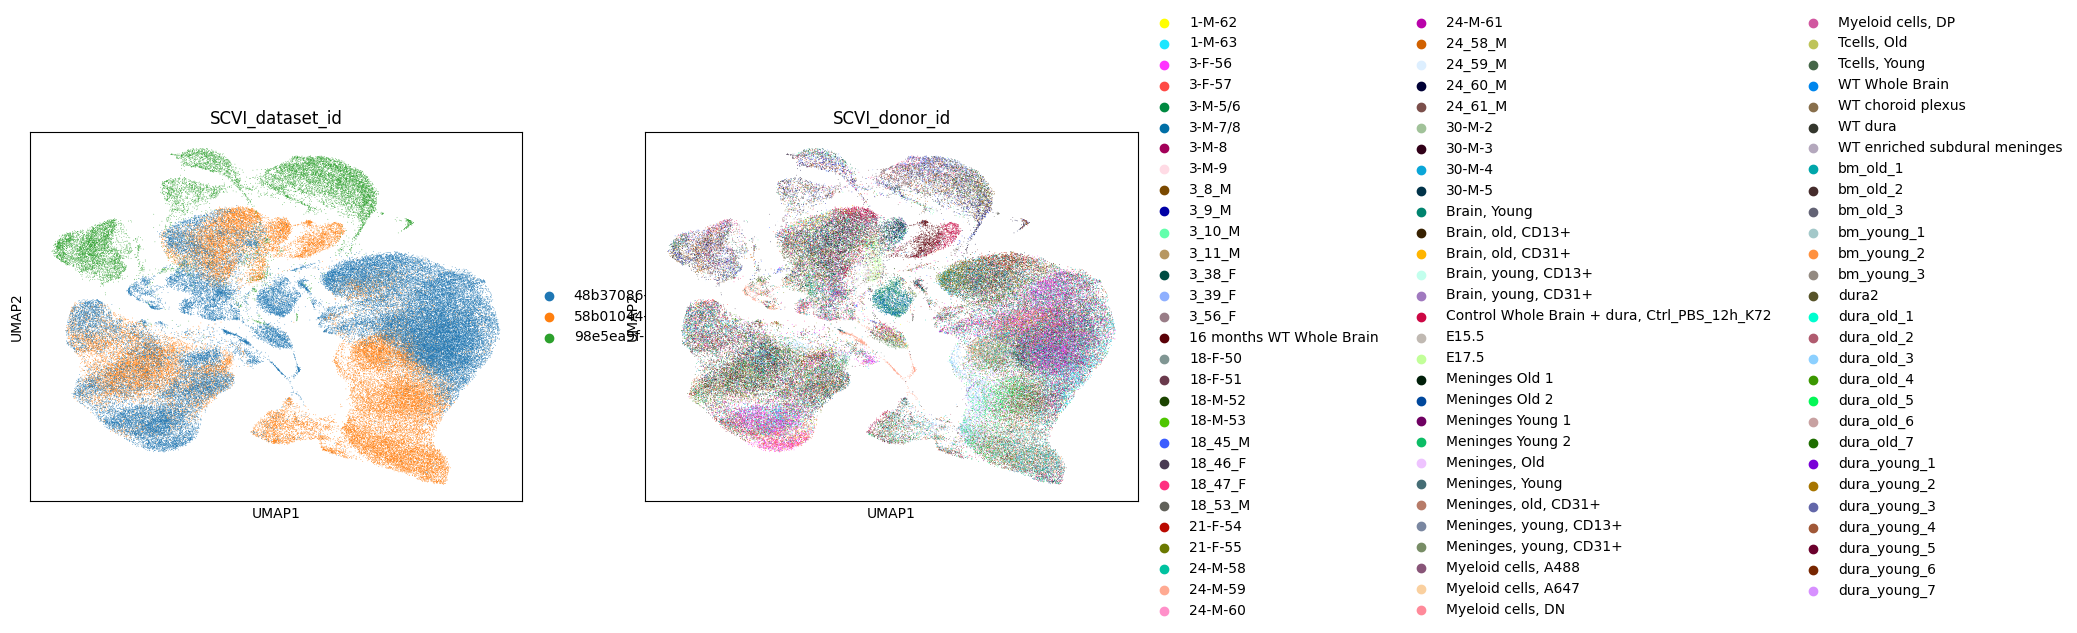

In [24]:
sc.pl.umap(
    adata,
    color=["dataset_id", "donor_id"],
    title=["SCVI_" + x for x in ["dataset_id", "donor_id"]],
)

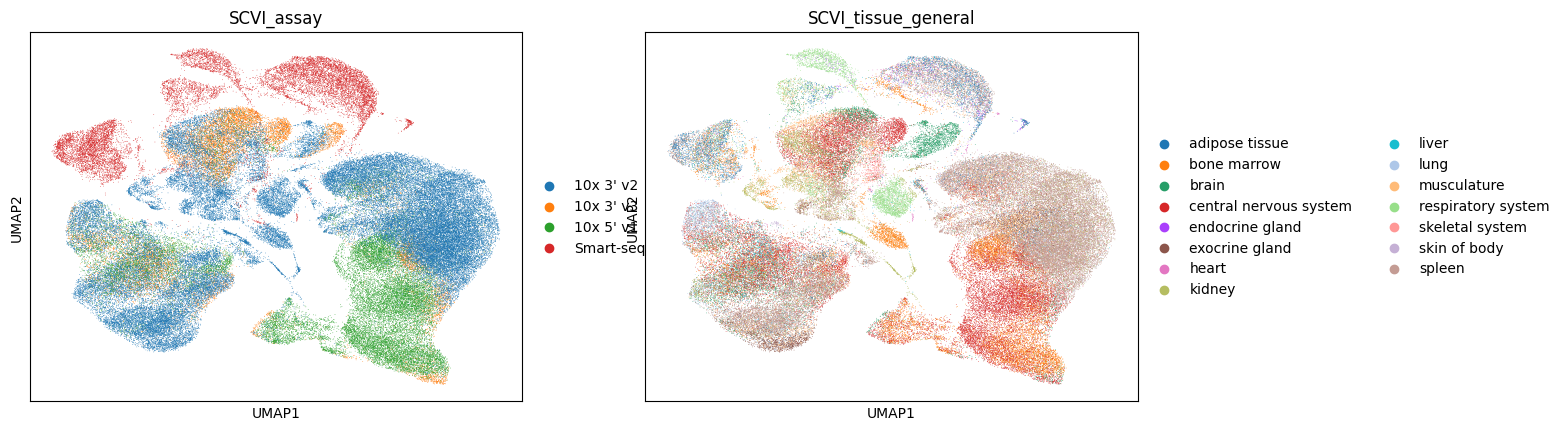

In [25]:
sc.pl.umap(
    adata,
    color=["assay", "tissue_general"],
    title=["SCVI_" + x for x in ["assay", "tissue_general"]],
)

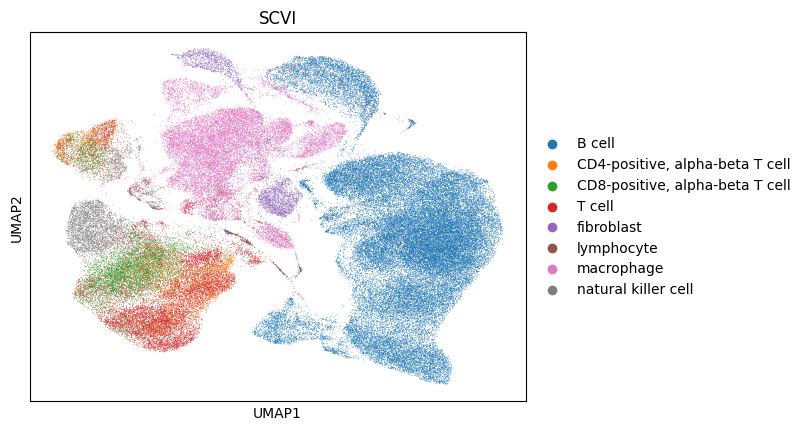

In [26]:
sc.pl.umap(adata, color="cell_type", title="SCVI")

lets train the actual adata that we extracted the normal way in order to see the integration 

In [27]:
adata.obs["batch"] = adata.obs[batch_keys].agg("//".join, axis=1).astype("category")

In [28]:
adata.obs["batch"].nunique()

307

In [29]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

In [30]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=top_n_hvg,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="dataset_id",
)

In [31]:
adata

AnnData object with n_obs × n_vars = 114440 × 5000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'scvi', 'umap', 'dataset_id_colors', 'donor_id_colors', 'assay_colors', 'tissue_general_colors', 'cell_type_colors', 'log1p', 'hvg'
    obsm: 'scvi', 'X_umap'
    layers: 'counts'
    obsp: 'scvi_

In [32]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", categorical_covariate_keys=batch_keys)

In [33]:
# model_census3 = scvi.model.SCVI.load("census_model", adata=adata)
model_census3 = scvi.model.SCVI(adata)

In [34]:
start2 = time.time()
model_census3.train(
    max_epochs=100,
)
end2 = time.time()
print(f"Elapsed time: {end2 - start2:.2f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Elapsed time: 370.58 seconds


In [35]:
model_census3.history["elbo_train"]

elbo_train
epoch             
0      1671.503906
1      1538.827148
2      1511.675049
3       1495.59021
4      1485.269897
...            ...
95     1428.516357
96     1428.402954
97     1428.232544
98     1428.359497
99     1428.145386

[100 rows x 1 columns]

In [36]:
adata.obsm["scvi_non_dataloder"] = model_census3.get_latent_representation()

In [37]:
sc.pp.neighbors(adata, use_rep="scvi_non_dataloder", key_added="scvi_non_dataloder")
sc.tl.umap(adata, neighbors_key="scvi_non_dataloder")

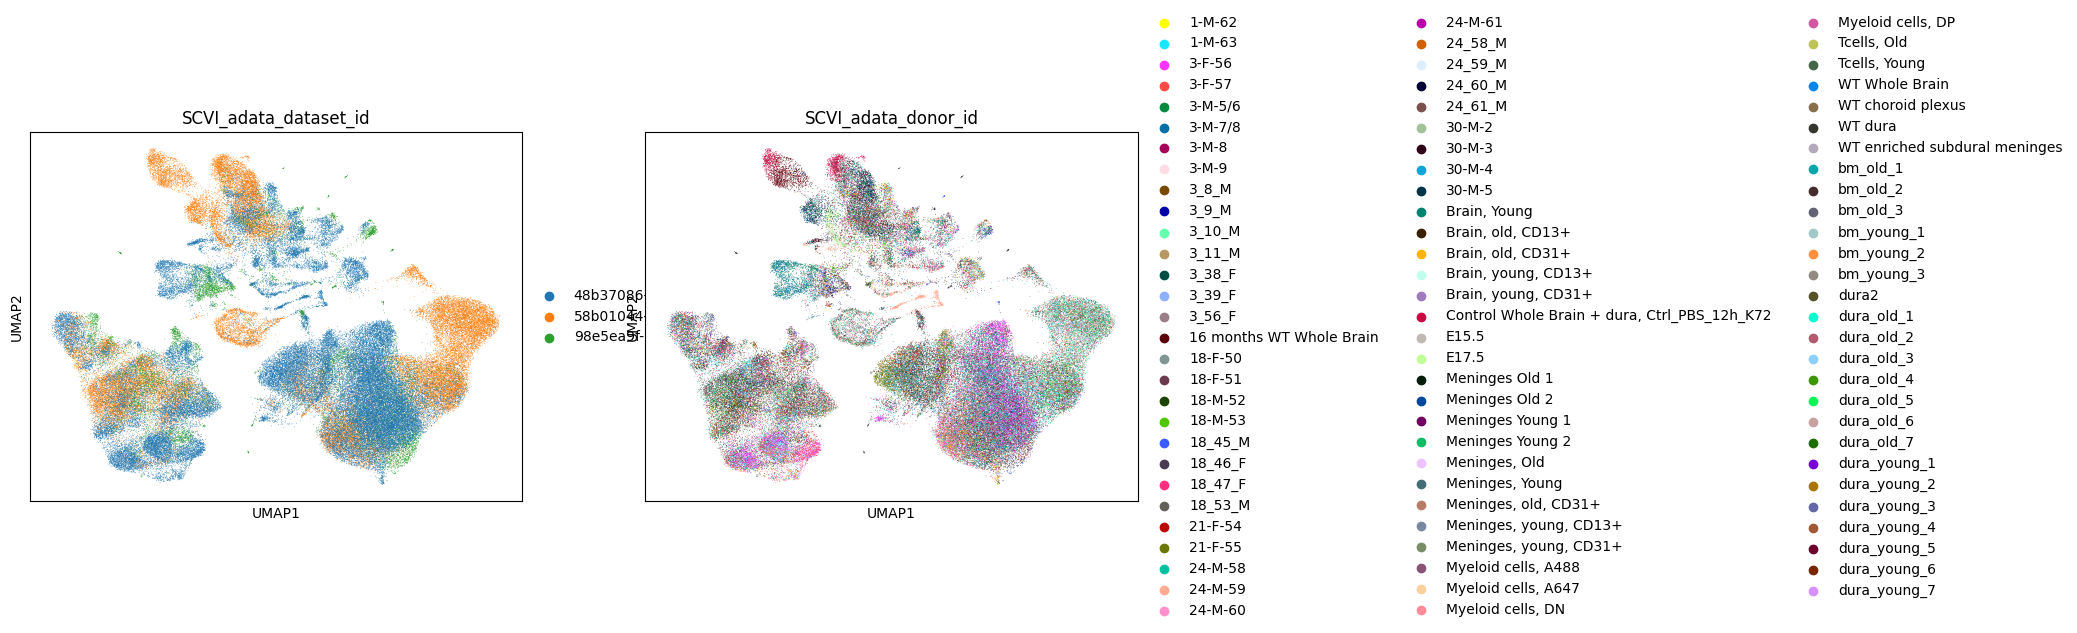

In [38]:
sc.pl.umap(
    adata,
    color=["dataset_id", "donor_id"],
    title=["SCVI_adata_" + x for x in ["dataset_id", "donor_id"]],
)

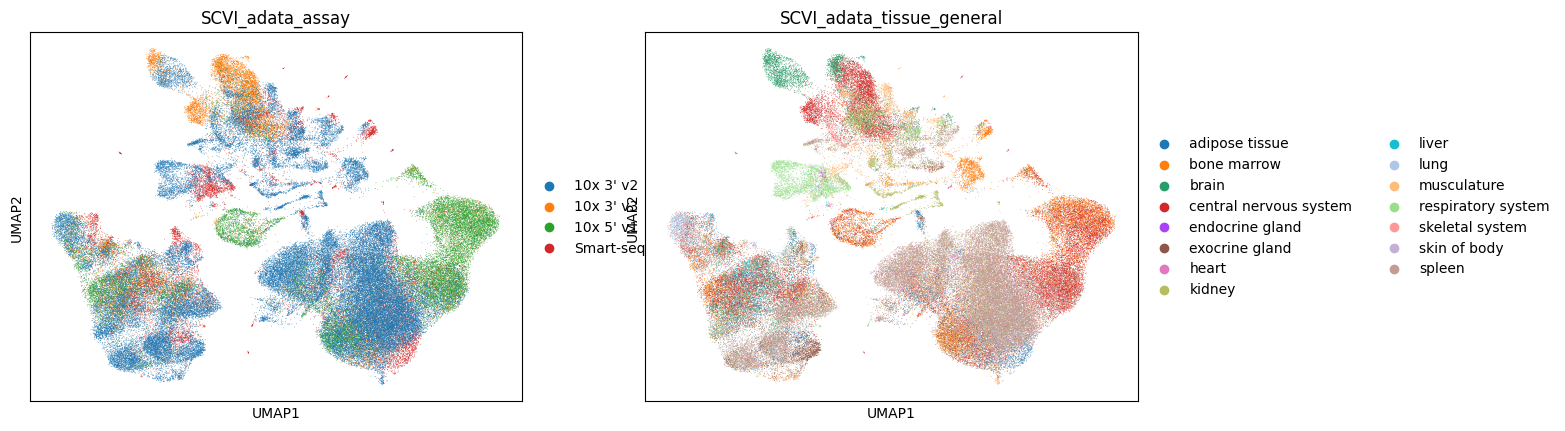

In [39]:
sc.pl.umap(
    adata,
    color=["assay", "tissue_general"],
    title=["SCVI_adata_" + x for x in ["assay", "tissue_general"]],
)

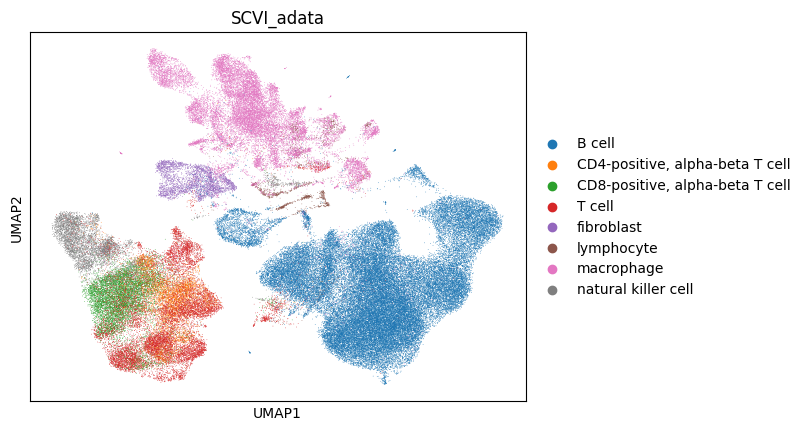

In [40]:
sc.pl.umap(adata, color="cell_type", title="SCVI_adata")

## SCANVI

In [82]:
import gc

gc.collect()
# del model_scanvi
# del datamodule_scanvi

0

In [42]:
label_keys = ["cell_type"]
datamodule_scanvi = TileDBDataModule(
    hvg_query,
    layer_name="raw",
    batch_size=8192,
    shuffle=True,
    seed=42,
    batch_column_names=batch_keys,
    label_keys=label_keys,
    unlabeled_category="label_0",
    model_name="SCANVI",
    dataloader_kwargs={"num_workers": 64, "persistent_workers": False},
)
print(
    datamodule_scanvi.n_obs,
    datamodule_scanvi.n_vars,
    datamodule_scanvi.n_batch,
    datamodule_scanvi.n_labels,
)

114440 5000 307 8


In [43]:
datamodule_scanvi.label_keys

['cell_type']

In [44]:
# datamodule_scanvi.registry

In [45]:
# datamodule.registry

In [46]:
# We can now create the scanVI model object and train it:
datamodule_scanvi.setup()
model_scanvi = scvi.model.SCANVI(
    adata=None,
    registry=datamodule_scanvi.registry,
    n_layers=n_layers,
    n_latent=n_latent,
    gene_likelihood="nb",
    encode_covariates=False,
    datamodule=datamodule_scanvi,
)

In [47]:
# model_scanvi = scvi.model.SCANVI.from_scvi_model(
#    scvi_model=model,
#    adata=None,
#    registry=datamodule_scanvi.registry,
#    encode_covariates=False,
#    labels_key="cell_type",
#    unlabeled_category="Unknown",
#    datamodule=datamodule_scanvi,
# )

In [83]:
start3 = time.time()
model_scanvi.train(
    datamodule=datamodule_scanvi,
    max_epochs=30,
    batch_size=8192,
    plan_kwargs={"lr": 2e-2},
    early_stopping=False,
    n_samples_per_label=100,
)
end3 = time.time()
print(f"Elapsed time: {end3 - start3:.2f} seconds")

INFO     Training for 10 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Elapsed time: 2228.98 seconds


In [79]:
model_scanvi.history.keys()

dict_keys(['train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'train_classification_loss', 'train_accuracy', 'train_f1_score', 'train_calibration_error'])

In [84]:
model_scanvi.history["train_accuracy"]

train_accuracy
epoch               
0           0.484585
1           0.569968
2           0.727276
3           0.744968
4           0.786581
5           0.785343
6           0.801118
7           0.810343
8           0.823003
9           0.828474
10          0.832628
11          0.844369
12          0.871845
13          0.882468
14          0.894808
15          0.891414
16          0.904433
17          0.910783
18          0.938458
19          0.938099
20          0.855072
21           0.88155
22          0.908147
23          0.916773
24          0.952476
25          0.953035
26          0.964217
27          0.948802
28          0.878914
29          0.897125

In [51]:
# model_scanvi.save(
#    "census_model_scanvi", save_anndata=False, overwrite=True, datamodule=datamodule_scanvi
# )

In [52]:
label_keys

['cell_type']

In [85]:
# Generate cell embeddings
inference_datamodule = TileDBDataModule(
    hvg_query,
    layer_name="raw",
    batch_labels=datamodule_scanvi.batch_labels,
    batch_size=8192,
    shuffle=False,
    batch_column_names=batch_keys,
    label_keys=label_keys,
    unlabeled_category="label_0",
    model_name="SCANVI",
    dataloader_kwargs={"num_workers": 64, "persistent_workers": False},
)
inference_datamodule.setup()

In [86]:
latent_scanvi = model_scanvi.get_latent_representation(
    dataloader=inference_datamodule.inference_dataloader()
)
latent_scanvi.shape

(114440, 10)

In [105]:
# model_scanvi.registry

In [88]:
# adata.obs

In [89]:
adata.obsm["scanvi"] = latent_scanvi

In [90]:
sc.pp.neighbors(adata, use_rep="scanvi", key_added="scanvi")
sc.tl.umap(adata, neighbors_key="scanvi")

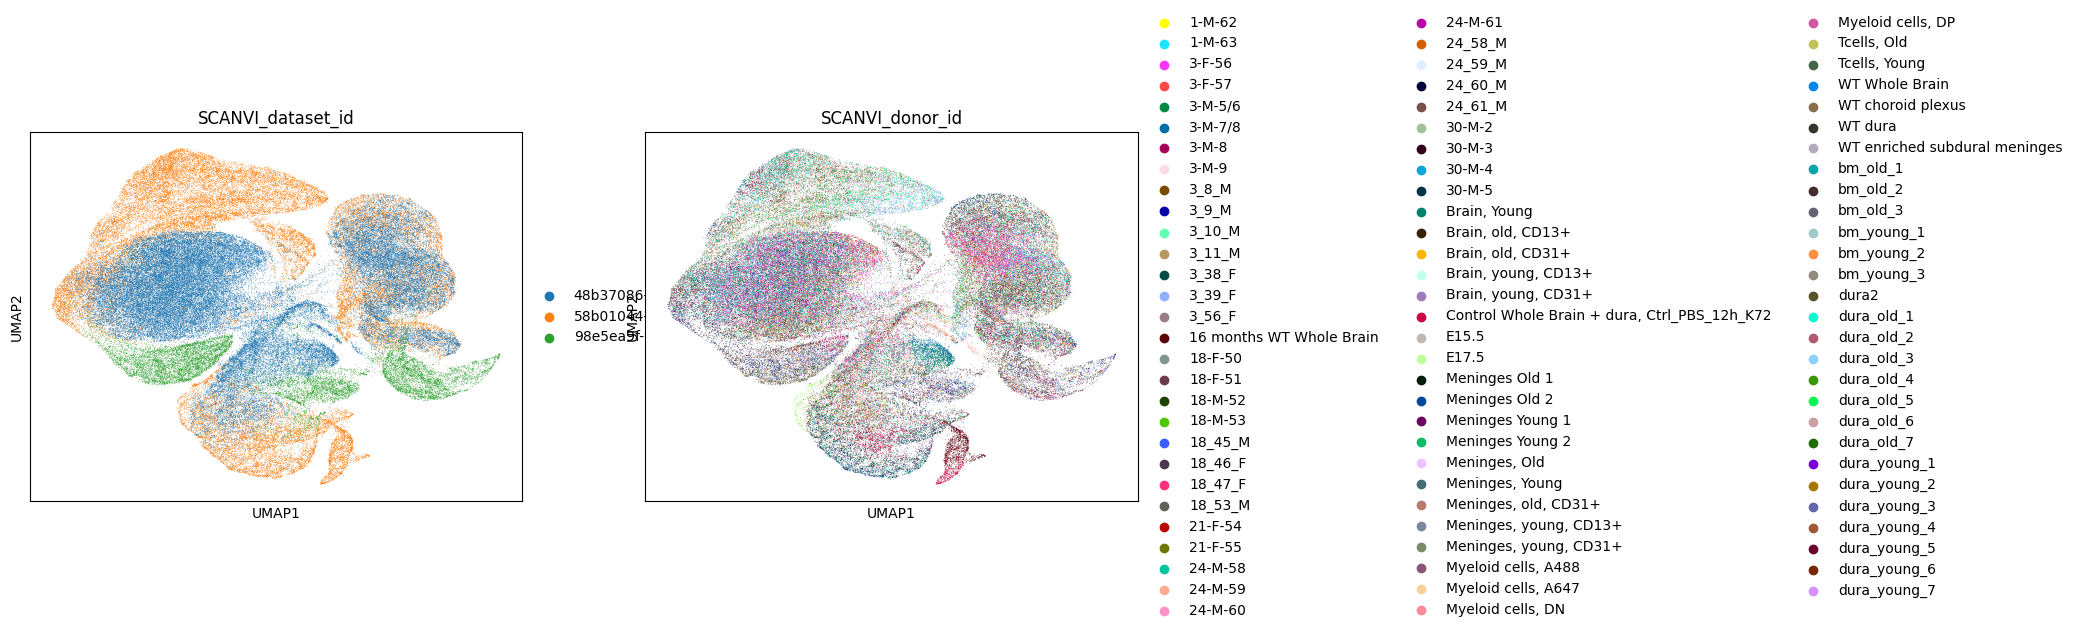

In [91]:
sc.pl.umap(
    adata,
    color=["dataset_id", "donor_id"],
    title=["SCANVI_" + x for x in ["dataset_id", "donor_id"]],
)

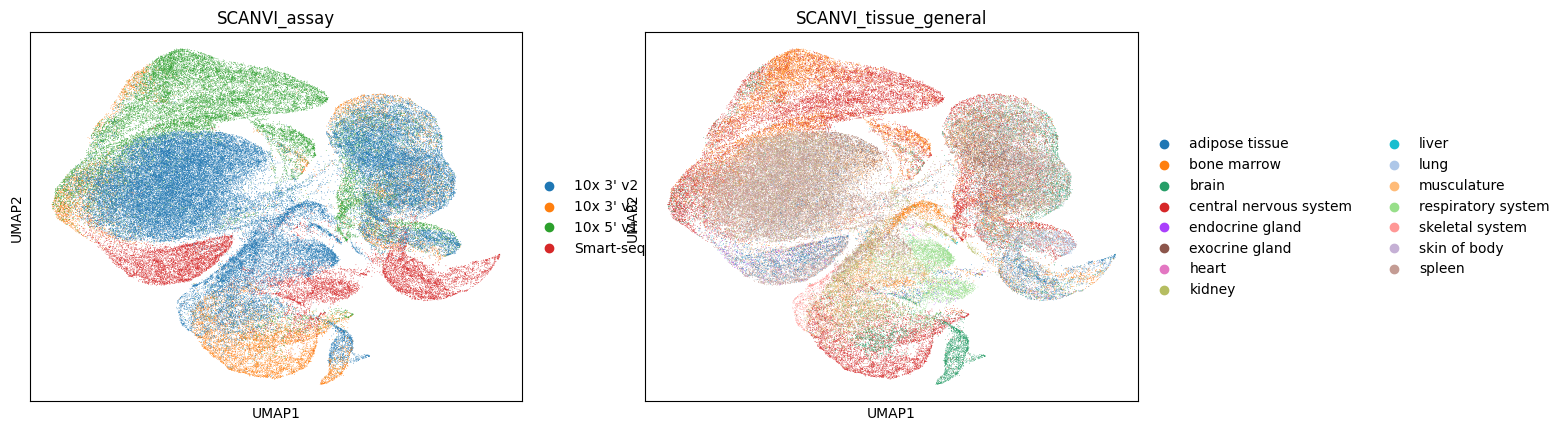

In [92]:
sc.pl.umap(
    adata,
    color=["assay", "tissue_general"],
    title=["SCANVI_" + x for x in ["assay", "tissue_general"]],
)

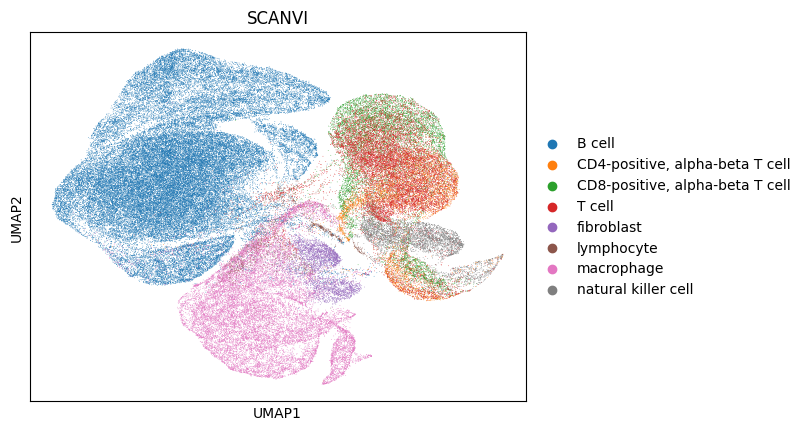

In [93]:
sc.pl.umap(adata, color="cell_type", title="SCANVI")

Calculate Predictions

In [100]:
adata.obs["predictions_scanvi"] = model_scanvi.predict(
    dataloader=inference_datamodule.inference_dataloader(), batch_size=8192
)

In [101]:
adata.obs["cell_type"].value_counts()

cell_type
B cell                             59202
macrophage                         19305
T cell                             12745
CD8-positive, alpha-beta T cell     7938
natural killer cell                 5454
CD4-positive, alpha-beta T cell     5091
fibroblast                          3143
lymphocyte                          1562
Name: count, dtype: int64

In [102]:
adata.obs["predictions_scanvi"].value_counts()

predictions_scanvi
natural killer cell                59182
macrophage                         29988
fibroblast                         17059
lymphocyte                          4152
CD4-positive, alpha-beta T cell     4059
Name: count, dtype: int64

Text(0, 0.5, 'Observed')

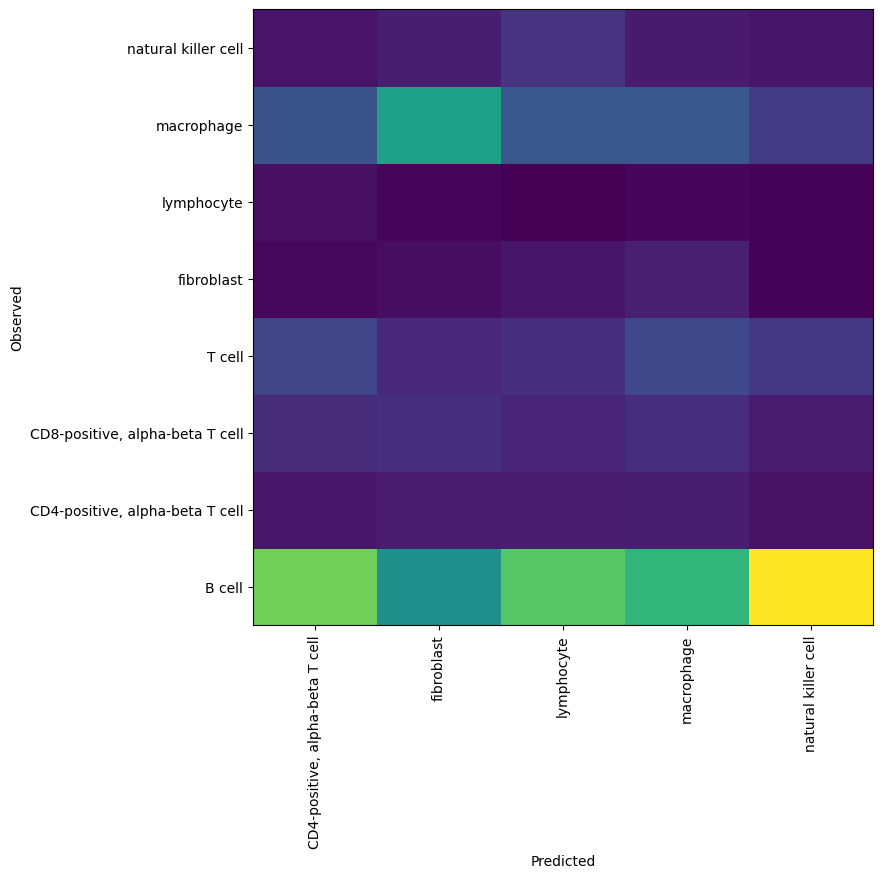

In [103]:
df = adata.obs.groupby(["cell_type", "predictions_scanvi"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

## Compare to regular SCANVI

In [66]:
scvi.model.SCANVI.setup_anndata(
    adata,
    layer="counts",
    labels_key="cell_type",
    unlabeled_category="label_0",
    categorical_covariate_keys=batch_keys,
)

In [67]:
# model_census4 = scvi.model.SCVI.load("census_model", adata=adata)
model_census4 = scvi.model.SCANVI(adata)

In [68]:
start4 = time.time()
model_census4.train(
    max_epochs=100,
)
end4 = time.time()
print(f"Elapsed time: {end4 - start4:.2f} seconds")

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Elapsed time: 1059.75 seconds


In [69]:
model_census4.history["elbo_train"]

elbo_train
epoch             
0      1726.080688
1      1567.483765
2      1532.582031
3      1512.073486
4      1499.513672
...            ...
95     1434.601562
96     1434.525024
97     1434.284668
98     1434.301514
99     1434.200928

[100 rows x 1 columns]

In [70]:
adata.obsm["scanvi_non_dataloder"] = model_census4.get_latent_representation()

In [71]:
sc.pp.neighbors(adata, use_rep="scanvi_non_dataloder", key_added="scanvi_non_dataloder")
sc.tl.umap(adata, neighbors_key="scanvi_non_dataloder")

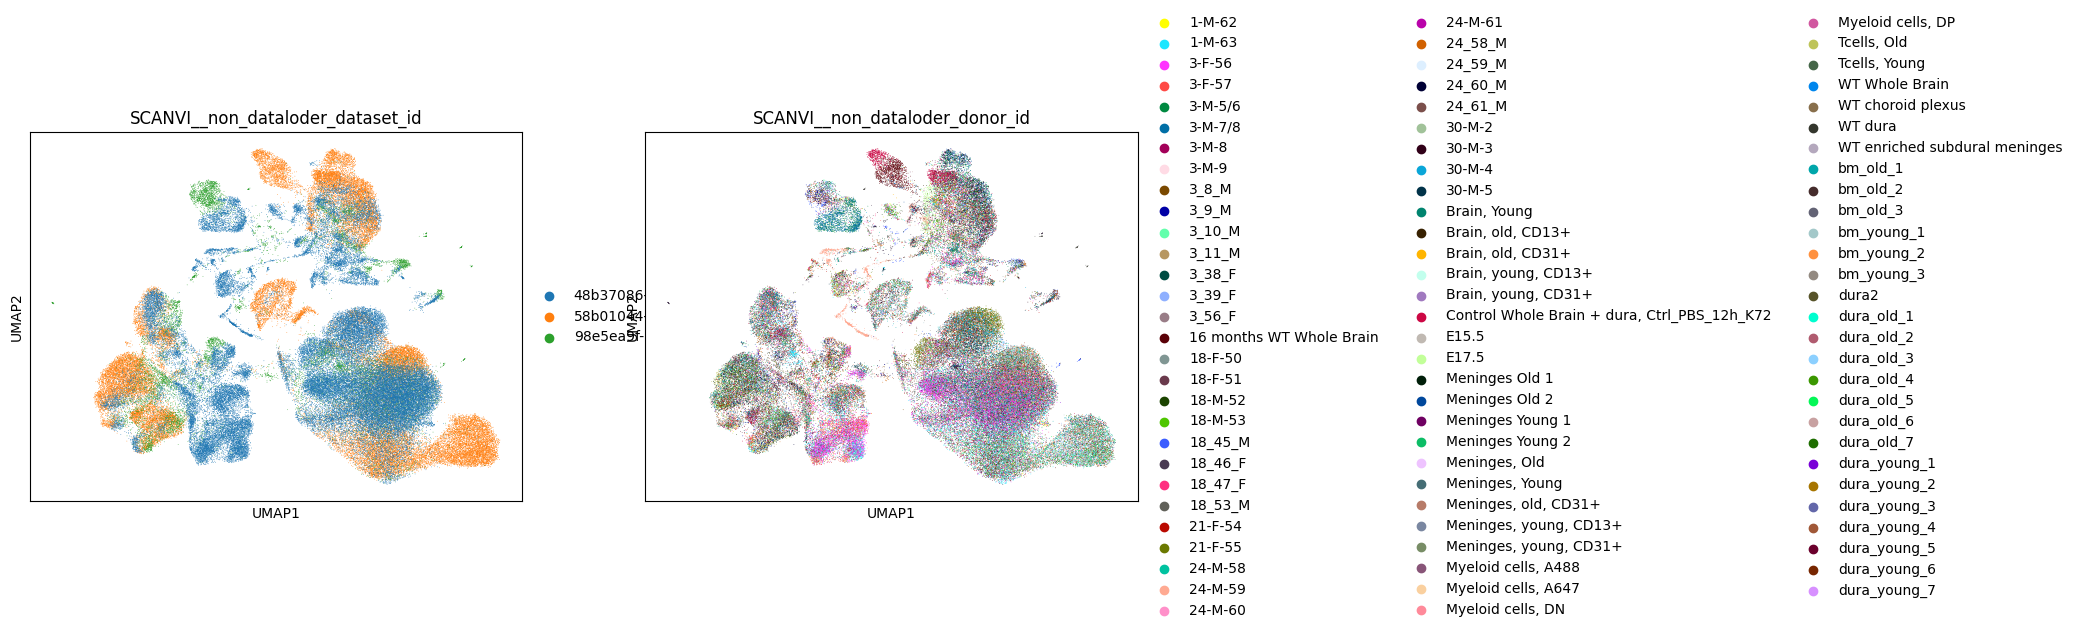

In [72]:
sc.pl.umap(
    adata,
    color=["dataset_id", "donor_id"],
    title=["SCANVI__non_dataloder_" + x for x in ["dataset_id", "donor_id"]],
)

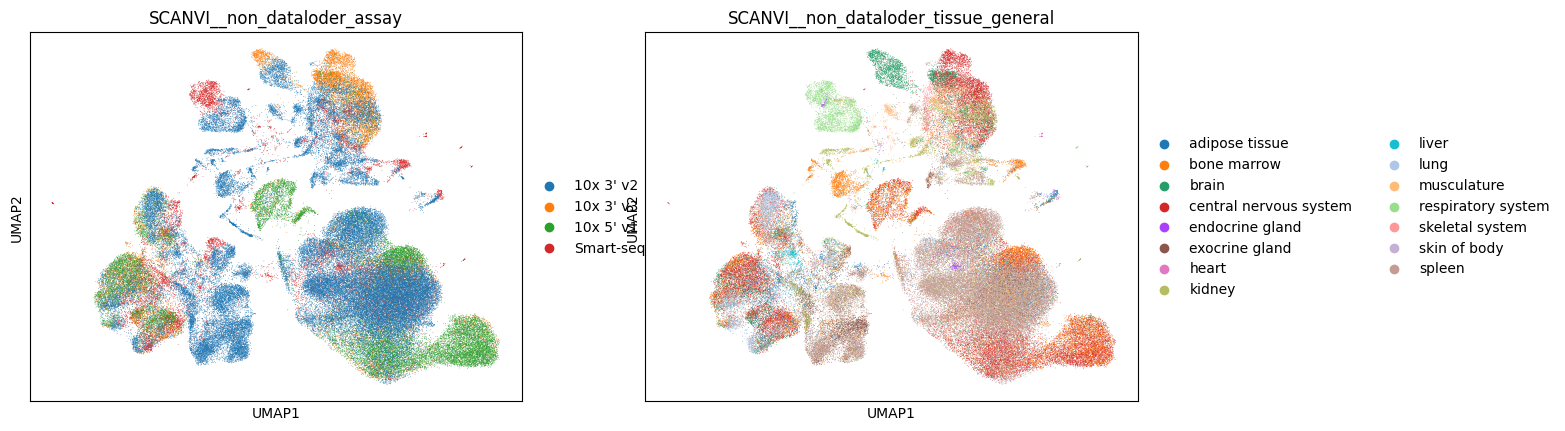

In [73]:
sc.pl.umap(
    adata,
    color=["assay", "tissue_general"],
    title=["SCANVI__non_dataloder_" + x for x in ["assay", "tissue_general"]],
)

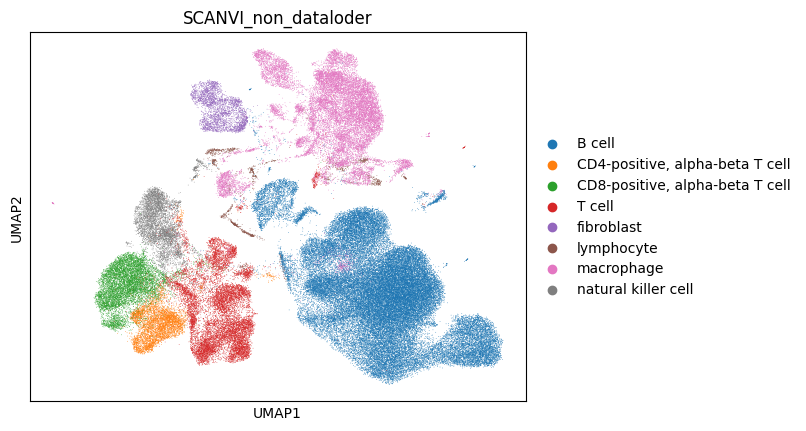

In [74]:
sc.pl.umap(adata, color="cell_type", title="SCANVI_non_dataloder")

In [75]:
adata.obs["predictions_scanvi_non_dataloder"] = model_census4.predict()

Text(0, 0.5, 'Observed')

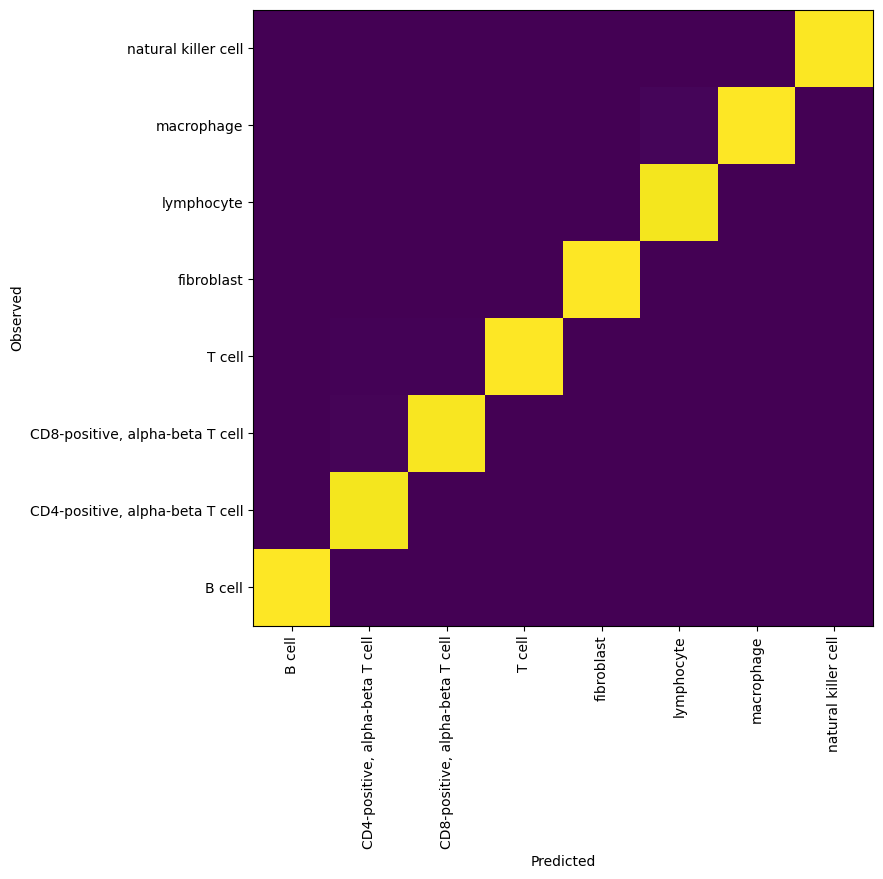

In [76]:
df = (
    adata.obs.groupby(["cell_type", "predictions_scanvi_non_dataloder"])
    .size()
    .unstack(fill_value=0)
)
norm_df = df / df.sum(axis=0)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

## Compute integration metrics

In [98]:
from scib_metrics.benchmark import Benchmarker

bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", "scvi", "scvi_non_dataloder", "scanvi", "scanvi_non_dataloder"],
    n_jobs=-1,
)
bm.benchmark()

rics:  60%|████████████████████████████████████████████████████▏                                  | 6/10 [00:06<00:04,  1.02s/it, Batch correction: kbet_per_label]

INFO     8 clusters consist of a single batch or are too small. Skip.                                              



Embeddings:  20%|███████████████████████▊                                                                                               | 1/5 [00:07<00:30,  7.50s/it]
                                                                                                                                                                   
rics:  60%|████████████████████████████████████████████████████▏                                  | 6/10 [00:03<00:01,  2.04it/s, Batch correction: kbet_per_label]

INFO     8 clusters consist of a single batch or are too small. Skip.                                              



Embeddings:  40%|███████████████████████████████████████████████▌                                                                       | 2/5 [00:11<00:16,  5.64s/it]
                                                                                                                                                                   
rics:  60%|████████████████████████████████████████████████████▏                                  | 6/10 [00:03<00:01,  2.05it/s, Batch correction: kbet_per_label]

INFO     8 clusters consist of a single batch or are too small. Skip.                                              



Embeddings:  60%|███████████████████████████████████████████████████████████████████████▍                                               | 3/5 [00:16<00:10,  5.03s/it]
                                                                                                                                                                   
rics:  60%|████████████████████████████████████████████████████▏                                  | 6/10 [00:03<00:02,  1.88it/s, Batch correction: kbet_per_label]

INFO     8 clusters consist of a single batch or are too small. Skip.                                              



Embeddings:  80%|███████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4/5 [00:20<00:04,  4.88s/it]
                                                                                                                                                                   
rics:  60%|████████████████████████████████████████████████████▏                                  | 6/10 [00:03<00:01,  2.04it/s, Batch correction: kbet_per_label]

INFO     8 clusters consist of a single batch or are too small. Skip.                                              



Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.02s/it]

                                                                                                                                                                   

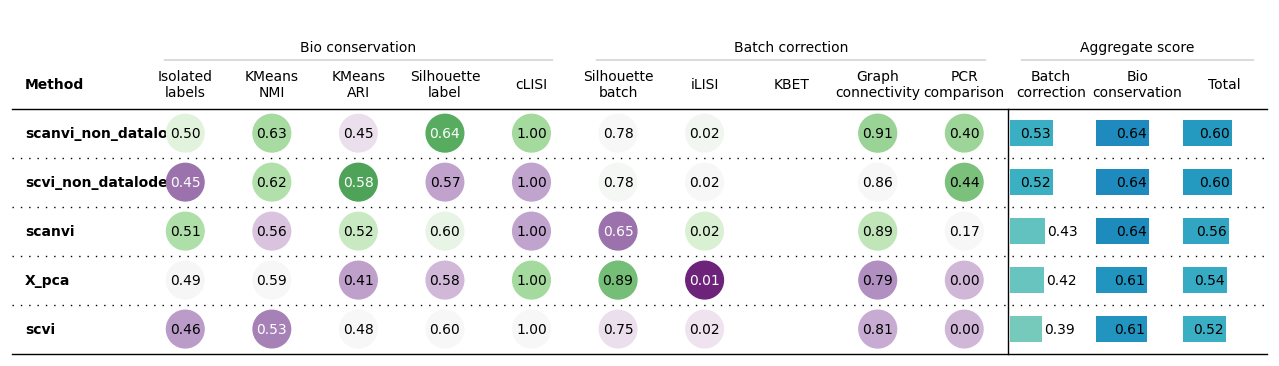

In [99]:
bm.plot_results_table(min_max_scale=False)